In [34]:
#We are going to fetch the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [35]:
#We can see there are 70.000 images, with 784 features each one
X, y = mnist["data"], mnist["target"]
X.shape


(70000, 784)

In [75]:
y.shape

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [91]:
#We want to be strigns in y
y = y.astype(np.uint8)

In [92]:
#To see which numbers do we have
import numpy as np
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [93]:
#The MNIST dataset has already the test set:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary detector

In [94]:
#We are going to identify the digit 5, so we create first the target vectors for the classification task
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [95]:
#Going to create now the SGD classicifer to train with the training set
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

### Performance measure

In [104]:
#We are giong to make a corss validation ourselves
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [105]:
#We can make another classifier for a image that is not in the 5 class
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
     def fit(self, X, y=None):
        pass
     def predict(self, X):
         return np.zeros((len(X), 1), dtype=bool)

In [107]:
#And the accuracy would be
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [111]:
#Accuracy is be the same as the probability of being 5 out of 10 numbers, so we will use the confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [113]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [114]:
#We are going to compute now the precision and recall
from sklearn.metrics import precision_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [115]:
from sklearn.metrics import recall_score
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [116]:
#We could compute the F1
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [118]:
#We will trturn decision scores to set the threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [124]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

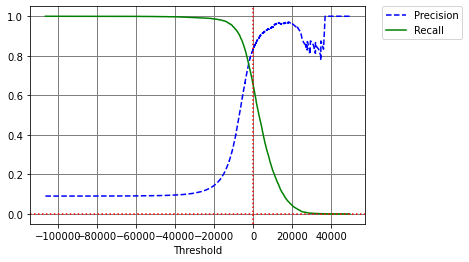

In [145]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
        plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
        plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    #To plot horizontal and vertical lines
        plt.axhline(c='r', ls=':')
        plt.axvline(c='r', ls=':')
    #Add a label, a legend and a grid
        plt.xlabel("Threshold")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


In [146]:
#Say i want a precision of 90%, so i want to compute the threshold
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [148]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

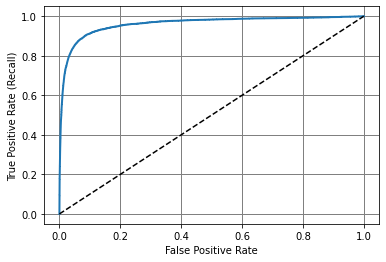

In [152]:
#We are going to plot the ROC curve from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve

#First we compute the TPR and FPR for varios threshold values
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

#Now you plot the FPR against the TPR using Matplotlip
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid(b=True, which="both", axis="both", color='gray', linestyle='-', linewidth=1)

plot_roc_curve(fpr, tpr)
plt.show()

In [154]:
#To measue the classifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest Classifier

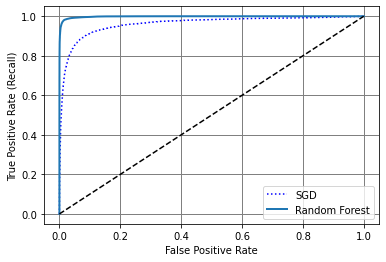

In [156]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

#Make the scores to compute the ROC curve
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

#Compute to compare also the anterior ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [157]:
#The score of the RFC is
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Multiclass Classification